In [1]:
%load_ext autoreload


In [2]:
%autoreload 2
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import mintpy
from osgeo import gdal
from mintpy.utils import plot as pp
from mintpy.utils import readfile, utils as ut 
import h5py
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mintpy import view
from mintpy.objects import timeseries
from operator import itemgetter 
import datetime
from datetime import timedelta
from scipy import interpolate
import matplotlib.dates as mdates
from miaplpy.objects.invert_pixel import process_pixel 
from scipy import stats
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.colors as mcolors

def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcolors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp


def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]


center = 0
divnorm = mcolors.TwoSlopeNorm(vmin=0,vcenter=0.3, vmax=1)
hex_list = ['#7B0099','#DF2A8E','#ff7b25', '#ffcc5c', '#ffeead']
cmapc=get_continuous_cmap(hex_list)
normc=divnorm

In [3]:
# referencing
# QUI4
#ref_lat = -0.140
#ref_lon = -78.467

ref_lat = -0.1395
ref_lon = -78.4671

# GGPA coords
Latitude_ggpa = -0.180
Longitude_ggpa = -78.594


#arbitrary point
lat_minopy1, lon_minopy1 = -0.1256, -78.5538

proj_dirs = ['./../DATA/Pichincha_data/minopy',
            './../DATA/Pichincha_data/mintpy']

out_dir = './out_figures'


#for prj in proj_dirs:
#    !reference_point.py $prj/velocity.h5 -l $ref_lat -L $ref_lon --lookup $prj/geometryRadar.h5
    

In [6]:
## read minopy files and generate masked lat, lon and velocity
wrap_range = [-1,1]

tsStack_minopy = proj_dirs[0] + '/timeseries_SET_ERA5_demErr.h5'
gStack_minopy = proj_dirs[0] + '/geometryRadar.h5'
velStack_minopy = proj_dirs[0] + '/velocity.h5'
tcoherence_minopy = proj_dirs[0] + '/temporalCoherence.h5'

latitude_minopy = readfile.read(gStack_minopy, datasetName='latitude')[0]
longitude_minopy = readfile.read(gStack_minopy, datasetName='longitude')[0]
height_minopy = readfile.read(gStack_minopy, datasetName='height')[0]
temporal_coherence_minopy = readfile.read(tcoherence_minopy, datasetName='temporalCoherence')[0]
velocity_minopy = readfile.read(velStack_minopy, datasetName='velocity')[0]
attr_minopy = readfile.read_attribute(tsStack_minopy)
velocity_minopy_del = readfile.read('/Volumes/SaraMNew/scratch/minopy_subsets/PichinchaSenDT142/delaunay/velocity.h5', 
                                datasetName='velocity')[0]

velocity_minopy_seq = readfile.read('/Volumes/SaraMNew/scratch/minopy_subsets/PichinchaSenDT142/seq_4/velocity.h5', 
                                datasetName='velocity')[0]

## read mintpy files and generate masked lat, lon and velocity

tsStack_mintpy = proj_dirs[1] + '/timeseries_SET_ERA5_demErr.h5'
gStack_mintpy = proj_dirs[1] + '/geometryRadar.h5'
velStack_mintpy = proj_dirs[1] + '/velocity.h5'
tcoherence_mintpy = proj_dirs[1] + '/temporalCoherence.h5'


#timeseries_mintpy = readfile.read(tsStack_mintpy, datasetName='timeseries')[0]
latitude_mintpy = readfile.read(gStack_mintpy, datasetName='latitude')[0]
longitude_mintpy = readfile.read(gStack_mintpy, datasetName='longitude')[0]
temporal_coherence_mintpy = readfile.read(tcoherence_mintpy, datasetName='temporalCoherence')[0]
velocity_mintpy = readfile.read(velStack_mintpy, datasetName='velocity')[0]
attr_mintpy = readfile.read_attribute(tsStack_mintpy)




In [7]:
from scipy.ndimage.filters import gaussian_filter
X = gaussian_filter(longitude_minopy, 0.9)
Y = gaussian_filter(latitude_minopy, 0.9)
Z = gaussian_filter(height_minopy, 0.9)

In [8]:
#minopy
threshold = 0.5
mask_minopy = temporal_coherence_minopy > threshold
rows_minopy, cols_minopy = np.where(mask_minopy)

lats_minopy = np.array(latitude_minopy[rows_minopy, cols_minopy])
lons_minopy = np.array(longitude_minopy[rows_minopy, cols_minopy])
vel_minopy = np.array(velocity_minopy[rows_minopy, cols_minopy])*100
vel_minopy_del = np.array(velocity_minopy_del[rows_minopy, cols_minopy])*100
vel_minopy_seq = np.array(velocity_minopy_seq[rows_minopy, cols_minopy])*100

# mintpy

threshold = 0.8
mask_mintpy = temporal_coherence_mintpy > threshold
rows_mintpy, cols_mintpy = np.where(mask_mintpy)

lats_mintpy = np.array(latitude_mintpy[rows_mintpy, cols_mintpy])
lons_mintpy = np.array(longitude_mintpy[rows_mintpy, cols_mintpy])
vel_mintpy = np.array(velocity_mintpy[rows_mintpy, cols_mintpy])*100



view.py ./../DATA/Pichincha_data/mintpy/geo/geo_velocity.h5 velocity -m ./../DATA/Pichincha_data/mintpy/geo/geo_maskTempCoh.h5 --notitle --nocbar --alpha 0.0001 --lalo-step 0.02 --lalo-loc 0 0 0 0 -u cm -c jet --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --nomultilook --dem ./../DATA/Pichincha_data/demLat_S02_N02_Lon_W080_W076.dem.wgs84 --contour-step 400 --contour-smooth 0.0 --shade-az 45 --shade-exag 0.01 --shade-min -4000 --shade-max 4000 --contour-linewidth 0.8 --sub-lat -0.225 -0.1 --sub-lon -78.64 -78.46 --fontsize 28 -v -2 1.4
view.py ./../DATA/Pichincha_data/mintpy/geo/geo_velocity.h5 velocity -m ./../DATA/Pichincha_data/mintpy/geo/geo_maskTempCoh.h5 --notitle --nocbar --alpha 0.0001 --lalo-step 0.02 --lalo-loc 0 0 0 0 -u cm -c jet --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --nomultilook --dem ./../DATA/Pichincha_data/demLat_S02_N02_Lon_W080_W076.dem.wgs84 --contour-step 400 --contour-smooth 0.0 --shade-az 45 --shade-exag 0.01 --shade-min -4000 --sha

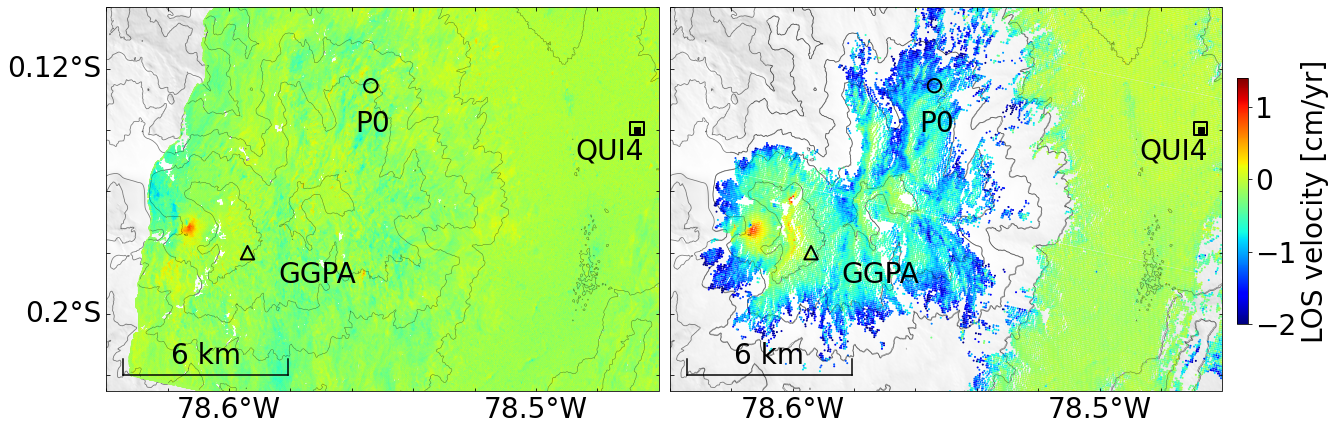

In [59]:
points_lalo = [(Latitude_ggpa, Longitude_ggpa),
              (lat_minopy1, lon_minopy1)]

wrap_range = [-1, 1]

plt.rcParams["font.size"] = "28"

fsize = 20

box = ['-0.225:-0.10','-78.64:-78.46'] 

lat = [float(i) for i in box[0].split(':')]
lon = [float(i) for i in box[1].split(':')]

#points_lalo = np.array([(-0.1718, -78.6134), (-0.1694, -78.6080)])

dem_file_1 = os.path.expanduser('./../DATA/Pichincha_data/demLat_S02_N02_Lon_W080_W076.dem.wgs84')

factor = [1]


# options for view.py

opt = ' --notitle --nocbar --alpha 0.0001 '
opt += ' --lalo-step 0.02 --lalo-loc 0 0 0 0 -u cm -c jet '
opt += ' --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 '
opt += ' --noverbose --nomultilook ' #.format(reflat, reflon)


fig, axs = plt.subplots(nrows=1, ncols=2, 
                        figsize=(20,11.4), subplot_kw=dict(projection=ccrs.PlateCarree()))


for i in range(2):
    
    ax = axs[i]
    ax.set_extent([lon[0], lon[1], lat[0], lat[1]], crs=ccrs.PlateCarree())

    data_pich = proj_dirs[1] + '/geo/geo_velocity.h5'
    mask_pich = proj_dirs[1] + '/geo/geo_maskTempCoh.h5'


    cmd = 'view.py {} velocity -m {}'.format(data_pich, mask_pich) + opt 
    cmd += ' --dem {} --contour-step 400 --contour-smooth 0.0 --shade-az 45 '.format(dem_file_1)
    cmd += ' --shade-exag 0.01 --shade-min -4000 --shade-max 4000 --contour-linewidth 0.8 '
    cmd += ' --sub-lat {} {} --sub-lon {} {} --fontsize 28 '.format(lat[0], lat[1], lon[0], lon[1])
    #cmd += ' --wrap --wrap-range -{f} {f} '.format(f=wrap_range[1])
    cmd += ' -v -2 1.4 '


    d_v, atr, inps = view.prep_slice(cmd)
    im, cbar = view.plot_slice(ax, d_v, atr, inps)[2:4]
    
    
    if i == 0:
        im = ax.scatter(lons_minopy, lats_minopy, c=vel_minopy, cmap='jet',  vmin=-2, vmax=1.4,
                    s=1, alpha=1, transform=ccrs.PlateCarree())
    else:
        im = ax.scatter(lons_mintpy, lats_mintpy, c=vel_mintpy, cmap='jet',  vmin=-2, vmax=1.4,
                     s=1, alpha=1, transform=ccrs.PlateCarree())
                     
    
    
    ax.contour(X, Y, Z, 6, colors='k', alpha=0.5, linewidths=0.5, transform=ccrs.PlateCarree())
    
    ax.scatter(ref_lon, ref_lat, s=180, c='None', alpha=1, edgecolors='black', 
                   linewidths=2, marker='s', transform=ccrs.PlateCarree())

    ax.scatter(points_lalo[0][1], points_lalo[0][0],s=180, c='None', alpha=1, edgecolors='black', 
                   linewidths=2, marker='^', transform=ccrs.PlateCarree())
    ax.scatter(points_lalo[1][1], points_lalo[1][0],s=180, c='None', alpha=1, edgecolors='black', 
                   marker='o', linewidths=2, transform=ccrs.PlateCarree())


    ax.text(points_lalo[0][1] + 0.01, points_lalo[0][0]-0.01,'GGPA', color='black', transform=ccrs.PlateCarree())
    ax.text(points_lalo[1][1] - 0.005, points_lalo[1][0]-0.015,'P0', color='black', transform=ccrs.PlateCarree())
    ax.text(ref_lon - 0.02, ref_lat-0.01,'QUI4', color='black', transform=ccrs.PlateCarree())

    gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0, color='black', alpha=0.5, linestyle='--', draw_labels=True)
    gl.xlabels_top = False
    gl.xlabels_bottom = True
    gl.ylabels_left = False
    gl.ylabels_right=False
    gl.xlines = True
    gl.xlocator = mticker.FixedLocator([-78.6, -78.5])
    gl.ylocator = mticker.FixedLocator([-0.2, -0.12])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    if i == 0:
        gl.ylabels_left = True
#gl.xlabel_style = {'color': 'red', 'weight': 'bold'}


#cbar_ax = fig.add_axes([0.44, 0.1, 0.15, 0.01])
cbar_ax = fig.add_axes([0.91, 0.35, 0.008, 0.3])

fig.colorbar(im, cax=cbar_ax, ticks=[-2, -1,0,1], label='LOS velocity [cm/yr]', orientation='vertical', pad =0.1)


fig.subplots_adjust(hspace=0.02, wspace=0.02)

#fig.subplots_adjust(wspace=0.02, hspace=0.02, left=0.05, right=0.95, top=0.95, bottom=0.05)      

ax.axes.get_xaxis().set_visible(True)
#ax.axes.get_ticklabels().set_visible(True)

out_file = os.path.abspath(out_dir + '/velocity_pichincha_compare.png')
#plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=300)
print('save figure to file', out_file)
plt.show()




view.py ./../DATA/Pichincha_data/mintpy/geo/geo_velocity.h5 velocity -m ./../DATA/Pichincha_data/mintpy/geo/geo_maskTempCoh.h5 --alpha 0.0001 -c jet --notitle --nocbar --lalo-step 0.02 --lalo-loc 0 0 0 0 -u cm --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --nomultilook --dem ./../DATA/Pichincha_data/demLat_S02_N02_Lon_W080_W076.dem.wgs84 --contour-step 400 --contour-smooth 0.0 --shade-az 45 --shade-exag 0.01 --shade-min -4000 --shade-max 4000 --contour-linewidth 0.8 --sub-lat -0.225 -0.1 --sub-lon -78.64 -78.46 --fontsize 28 -v -2 1.4
view.py /Volumes/SaraMNew/scratch/EcuadorChunch1SSenDT142/mintpy/geo/gg95.h5 --alpha 1 -c gray --notitle --nocbar --lalo-step 0.02 --lalo-loc 0 0 0 0 -u cm --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --nomultilook --sub-lat -0.225 -0.1 --sub-lon -78.64 -78.46 --fontsize 28 -v -1 0
Un-scalable display unit: cm
view.py ./../DATA/Pichincha_data/mintpy/geo/geo_velocity.h5 velocity -m ./../DATA/Pichincha_data/mintpy/geo/geo_maskTempCo

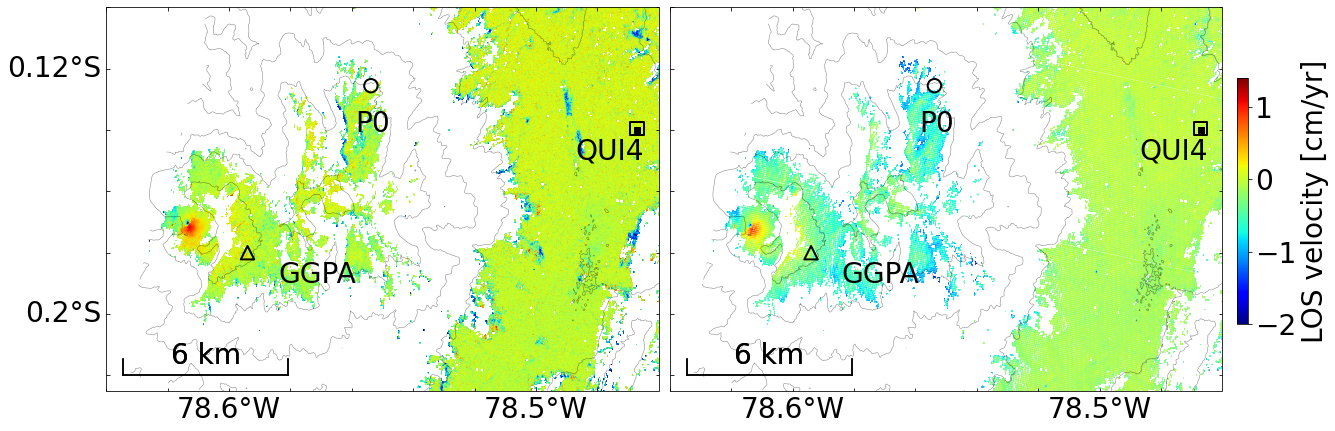

In [102]:
points_lalo = [(Latitude_ggpa, Longitude_ggpa),
              (lat_minopy1, lon_minopy1)]

wrap_range = [-1, 1]

plt.rcParams["font.size"] = "28"

fsize = 20

box = ['-0.225:-0.10','-78.64:-78.46'] 

lat = [float(i) for i in box[0].split(':')]
lon = [float(i) for i in box[1].split(':')]

#points_lalo = np.array([(-0.1718, -78.6134), (-0.1694, -78.6080)])

dem_file_1 = os.path.expanduser('./../DATA/Pichincha_data/demLat_S02_N02_Lon_W080_W076.dem.wgs84')


factor = [1]


# options for view.py

opt = ' --notitle --nocbar '
opt += ' --lalo-step 0.02 --lalo-loc 0 0 0 0 -u cm '
opt += ' --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 '
opt += ' --noverbose --nomultilook ' #.format(reflat, reflon)


fig, axs = plt.subplots(nrows=1, ncols=2, 
                        figsize=(20,11.4), subplot_kw=dict(projection=ccrs.PlateCarree()))


for i in range(2):
    
    ax = axs[i]
    ax.set_extent([lon[0], lon[1], lat[0], lat[1]], crs=ccrs.PlateCarree())

    data_pich = proj_dirs[1] + '/geo/geo_velocity.h5'
    mask_pich = proj_dirs[1] + '/geo/geo_maskTempCoh.h5'
    #mask_pich = '/Volumes/SaraMNew/scratch/EcuadorChunch1SSenDT142/mintpy/geo/geo_maskTempCoh9.h5'


    cmd = 'view.py {} velocity -m {}  --alpha 0.0001 -c jet '.format(data_pich, mask_pich) + opt 
    cmd += ' --dem {} --contour-step 400 --contour-smooth 0.0 --shade-az 45 '.format(dem_file_1)
    cmd += ' --shade-exag 0.01 --shade-min -4000 --shade-max 4000 --contour-linewidth 0.8 '
    cmd += ' --sub-lat {} {} --sub-lon {} {} --fontsize 28 '.format(lat[0], lat[1], lon[0], lon[1])
    #cmd += ' --wrap --wrap-range -{f} {f} '.format(f=wrap_range[1])
    cmd += ' -v -2 1.4 '


    d_v, atr, inps = view.prep_slice(cmd)
    im, cbar = view.plot_slice(ax, d_v, atr, inps)[2:4]
    
    
    if i == 0:
        im = ax.scatter(lons_minopy, lats_minopy, c=vel_minopy_seq, cmap='jet',  vmin=-2, vmax=1.4,
                    s=1, alpha=1, transform=ccrs.PlateCarree())
    else:
        im = ax.scatter(lons_mintpy, lats_mintpy, c=vel_mintpy, cmap='jet',  vmin=-2, vmax=1.4,
                     s=1, alpha=1, transform=ccrs.PlateCarree())
                     
    #data_gg = '/Volumes/SaraMNew/scratch/EcuadorChunch1SSenDT142/mintpy/geocoded/gg.h5'
    data_gg = '/Volumes/SaraMNew/scratch/EcuadorChunch1SSenDT142/mintpy/geo/gg95.h5'
    
    cmd = 'view.py {} --alpha 1 -c gray'.format(data_gg) + opt 
    cmd += ' --sub-lat {} {} --sub-lon {} {} --fontsize 28 '.format(lat[0], lat[1], lon[0], lon[1])
    #cmd += ' --wrap --wrap-range -{f} {f} '.format(f=wrap_range[1])
    cmd += ' -v -1 0 '
    d_v, atr, inps = view.prep_slice(cmd)
    imgg, cbar = view.plot_slice(ax, d_v, atr, inps)[2:4]
    
    ax.contour(X, Y, Z, 6, colors='k', alpha=0.5, linewidths=0.5, transform=ccrs.PlateCarree())
    
    ax.scatter(ref_lon, ref_lat, s=180, c='None', alpha=1, edgecolors='black', 
                   linewidths=2, marker='s', transform=ccrs.PlateCarree())

    ax.scatter(points_lalo[0][1], points_lalo[0][0],s=180, c='None', alpha=1, edgecolors='black', 
                   linewidths=2, marker='^', transform=ccrs.PlateCarree())
    ax.scatter(points_lalo[1][1], points_lalo[1][0],s=180, c='None', alpha=1, edgecolors='black', 
                   marker='o', linewidths=2, transform=ccrs.PlateCarree())


    ax.text(points_lalo[0][1] + 0.01, points_lalo[0][0]-0.01,'GGPA', color='black', transform=ccrs.PlateCarree())
    ax.text(points_lalo[1][1] - 0.005, points_lalo[1][0]-0.015,'P0', color='black', transform=ccrs.PlateCarree())
    ax.text(ref_lon - 0.02, ref_lat-0.01,'QUI4', color='black', transform=ccrs.PlateCarree())

    gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0, color='black', alpha=0.5, linestyle='--', draw_labels=True)
    gl.xlabels_top = False
    gl.xlabels_bottom = True
    gl.ylabels_left = False
    gl.ylabels_right=False
    gl.xlines = True
    gl.xlocator = mticker.FixedLocator([-78.6, -78.5])
    gl.ylocator = mticker.FixedLocator([-0.2, -0.12])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    if i == 0:
        gl.ylabels_left = True
#gl.xlabel_style = {'color': 'red', 'weight': 'bold'}


#cbar_ax = fig.add_axes([0.44, 0.1, 0.15, 0.01])
cbar_ax = fig.add_axes([0.91, 0.35, 0.008, 0.3])

fig.colorbar(im, cax=cbar_ax, ticks=[-2, -1,0,1], label='LOS velocity [cm/yr]', orientation='vertical', pad =0.1)


fig.subplots_adjust(hspace=0.02, wspace=0.02)

#fig.subplots_adjust(wspace=0.02, hspace=0.02, left=0.05, right=0.95, top=0.95, bottom=0.05)      

ax.axes.get_xaxis().set_visible(True)
#ax.axes.get_ticklabels().set_visible(True)

#out_file = os.path.abspath(out_dir + '/velocity_pichincha_compare_delaunay.png')
#out_file = os.path.abspath(out_dir + '/velocity_pichincha_compare_single_ref.png')
out_file = os.path.abspath(out_dir + '/velocity_pichincha_compare_seq95.png')

plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=300)
print('save figure to file', out_file)
plt.show()


In [9]:
# referencing
# QUI4
#ref_lat = -0.140
#ref_lon = -78.467

ref_lat = -0.1395
ref_lon = -78.4671

# GGPA coords
Latitude_ggpa = -0.180
Longitude_ggpa = -78.594


#arbitrary point
lat_minopy1, lon_minopy1 = -0.1256, -78.5538

proj_dirs = ['/Volumes/SaraMNew/scratch/EcuadorChunch1SSenDT142/mintpy/geocoded',
            '/Volumes/SaraMNew/scratch/EcuadorChunch1SSenDT142/mintpy/geocoded']

out_dir = './out_figures'

#for prj in proj_dirs:
#    !reference_point.py $prj/velocity.h5 -l $ref_lat -L $ref_lon --lookup $prj/geometryRadar.h5
    

view.py /Volumes/SaraMNew/scratch/EcuadorChunch1SSenDT142/mintpy/geocoded/geo_cpmask.h5 --alpha 1 --notitle --nocbar --lalo-step 0.02 --lalo-loc 0 0 0 0 --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --nomultilook --dem ./../DATA/Pichincha_data/demLat_S02_N02_Lon_W080_W076.dem.wgs84 --contour-step 400 --contour-smooth 0.0 --shade-az 45 --shade-exag 0.01 --shade-min -4000 --shade-max 4000 --contour-linewidth 0.8 --sub-lat -0.225 -0.1 --sub-lon -78.64 -78.46 --fontsize 28 --noreference -c plasma
view.py /Volumes/SaraMNew/scratch/EcuadorChunch1SSenDT142/mintpy/geocoded/geo_numTriNonzeroIntAmbiguity.h5 --alpha 1 --notitle --nocbar --lalo-step 0.02 --lalo-loc 0 0 0 0 --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --nomultilook --dem ./../DATA/Pichincha_data/demLat_S02_N02_Lon_W080_W076.dem.wgs84 --contour-step 400 --contour-smooth 0.0 --shade-az 45 --shade-exag 0.01 --shade-min -4000 --shade-max 4000 --contour-linewidth 0.8 --sub-lat -0.225 -0.1 --sub-lon -78.64 -78.46

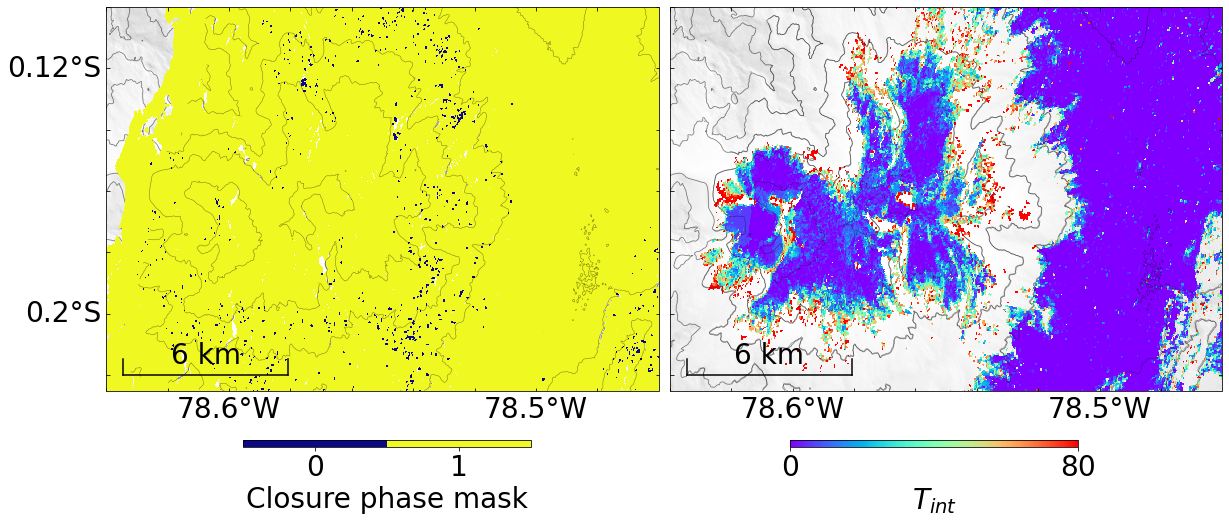

In [23]:
plt.rcParams["font.size"] = "28"

fsize = 20

box = ['-0.225:-0.10','-78.64:-78.46'] 

lat = [float(i) for i in box[0].split(':')]
lon = [float(i) for i in box[1].split(':')]

#points_lalo = np.array([(-0.1718, -78.6134), (-0.1694, -78.6080)])

dem_file_1 = os.path.expanduser('./../DATA/Pichincha_data/demLat_S02_N02_Lon_W080_W076.dem.wgs84')

factor = [1]


# options for view.py

opt = ' --notitle --nocbar  '
opt += ' --lalo-step 0.02 --lalo-loc 0 0 0 0  '
opt += ' --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 '
opt += ' --noverbose --nomultilook ' #.format(reflat, reflon)


fig, axs = plt.subplots(nrows=1, ncols=2, 
                        figsize=(20,11.4), subplot_kw=dict(projection=ccrs.PlateCarree()))


data = [proj_dirs[0] +'/geo_cpmask.h5', proj_dirs[0] +'/geo_numTriNonzeroIntAmbiguity.h5']
#data = ['/Volumes/SaraMNew/scratch/EcuadorChunch1SSenDT142/mintpy/geo_cpmask.h5', '/Volumes/SaraMNew/scratch/minopy_subsets/PichinchaSenDT142/seq_4/geo_numTriNonzeroIntAmbiguity.h5']

for i in range(2):
    
    ax = axs[i]
    ax.set_extent([lon[0], lon[1], lat[0], lat[1]], crs=ccrs.PlateCarree())

    data_pich = data[i] #proj_dirs[0] + '/{}'.format(data[i])
   
    mask_pich = proj_dirs[0] + '/geo_maskTempCoh.h5'


    cmd = 'view.py {} --alpha 1'.format(data_pich, mask_pich) + opt 
    cmd += ' --dem {} --contour-step 400 --contour-smooth 0.0 --shade-az 45 '.format(dem_file_1)
    cmd += ' --shade-exag 0.01 --shade-min -4000 --shade-max 4000 --contour-linewidth 0.8 '
    cmd += ' --sub-lat {} {} --sub-lon {} {} --fontsize 28 --noreference '.format(lat[0], lat[1], lon[0], lon[1])
    #cmd += ' --wrap --wrap-range -{f} {f} '.format(f=wrap_range[1])
    #if i==1:
    #    cmd += ' -v -2 1.4 '
    
    if i==0:
        cmd += ' -c plasma '
        d_v, atr, inps = view.prep_slice(cmd)
        im1, cbar = view.plot_slice(ax, d_v, atr, inps)[2:4]
        cbar_ax = fig.add_axes([0.22, 0.2, 0.2, 0.008])
        fig.colorbar(im1, cax=cbar_ax, ticks=[0,1], label='Closure phase mask', orientation='horizontal', pad =0.1)
        
    if i==1:
        cmd += ' -v 0 80 -m {} -c rainbow'.format(mask_pich)
        d_v, atr, inps = view.prep_slice(cmd)
        im2, cbar = view.plot_slice(ax, d_v, atr, inps)[2:4]
        cbar_ax = fig.add_axes([0.6, 0.2, 0.2, 0.008])
        fig.colorbar(im2, cax=cbar_ax, ticks=[0,80], label='$T_{int}$', orientation='horizontal', pad =0.1)
        #fig.colorbar(im2, cax=cbar_ax, label='% $T_{int}$', orientation='horizontal', pad =0.1)
                     
    
    ax.contour(X, Y, Z, 6, colors='k', alpha=0.5, linewidths=0.5, transform=ccrs.PlateCarree())
    
    #ax.scatter(ref_lon, ref_lat, s=180, c='None', alpha=1, edgecolors='black', 
    #               linewidths=2, marker='s', transform=ccrs.PlateCarree())

  
    #ax.text(ref_lon - 0.02, ref_lat-0.01,'QUI4', color='black', transform=ccrs.PlateCarree())

    gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0, color='black', alpha=0.5, linestyle='--', draw_labels=True)
    gl.xlabels_top = False
    gl.xlabels_bottom = True
    gl.ylabels_left = False
    gl.ylabels_right=False
    gl.xlines = True
    gl.xlocator = mticker.FixedLocator([-78.6, -78.5])
    gl.ylocator = mticker.FixedLocator([-0.2, -0.12])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    if i == 0:
        gl.ylabels_left = True
#gl.xlabel_style = {'color': 'red', 'weight': 'bold'}


#cbar_ax = fig.add_axes([0.44, 0.1, 0.15, 0.01])
#cbar_ax = fig.add_axes([0.91, 0.35, 0.008, 0.3])

#fig.colorbar(im, cax=cbar_ax, ticks=[-2, -1,0,1], label='LOS velocity [cm/yr]', orientation='vertical', pad =0.1)


fig.subplots_adjust(hspace=0.02, wspace=0.02)

#fig.subplots_adjust(wspace=0.02, hspace=0.02, left=0.05, right=0.95, top=0.95, bottom=0.05)      

ax.axes.get_xaxis().set_visible(True)
#ax.axes.get_ticklabels().set_visible(True)

out_file = os.path.abspath(out_dir + '/cpmask_pichincha_compare_minopy.png')
plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=300)
print('save figure to file', out_file)
plt.show()




In [43]:
gps_file = './../DATA/GPS_data/GGPA.tenv3.txt'
file1 = open(gps_file,"r") 
lines_ggpa = file1.readlines()
file1.close()


indx = np.hstack([1, np.arange(6,13), np.arange(14,17)]).astype(int)
gps_points_ggpa = []
for t in lines_ggpa:
        A = t.split()
        gps_points_ggpa.append(itemgetter(*indx)(A))
        

gps_file = './../DATA/GPS_data/QUI4.tenv3.txt'
file1 = open(gps_file,"r") 
lines_qui4 = file1.readlines()
file1.close()

indx = np.hstack([1, np.arange(6,13), np.arange(14,17)]).astype(int)
gps_points_qui4 = []
for t in lines_qui4:
        A = t.split()
        gps_points_qui4.append(itemgetter(*indx)(A))


In [44]:
tsStack_minopy = proj_dirs[0] + '/timeseries_SET_ERA5_demErr.h5'
gStack_minopy = proj_dirs[0] + '/geometryRadar.h5'

attr_minopy = readfile.read_attribute(tsStack_minopy)


tsStack_mintpy = proj_dirs[1] + '/timeseries_SET_ERA5_demErr.h5'
gStack_mintpy = proj_dirs[1] + '/geometryRadar.h5'

attr_mintpy = readfile.read_attribute(tsStack_mintpy)

# 

stack_obj = timeseries(tsStack_mintpy)
stack_obj.open(print_msg=False)
date_list_mintpy = stack_obj.get_date_list()
num_dates_mintpy = len(date_list_mintpy)

stack_obj = timeseries(tsStack_minopy)
stack_obj.open(print_msg=False)
date_list_minopy = stack_obj.get_date_list()
num_dates_minopy = len(date_list_minopy)


In [45]:

## gps
coord_minopy = ut.coordinate(attr_minopy, gStack_minopy)
yg_minopy, xg_minopy = coord_minopy.geo2radar(Latitude_ggpa, Longitude_ggpa)[0:2]
incangle_minopy = np.deg2rad(readfile.read(gStack_minopy, datasetName='incidenceAngle')[0][yg_minopy, xg_minopy])
azangle_minopy = np.deg2rad(float(attr_minopy['HEADING'])) # np.deg2rad(-12.01849365234375)   #np.deg2rad(float(atr_EMI['HEADING']))
#print(yg, xg, incangle, azangle)


coord_mintpy = ut.coordinate(attr_mintpy, gStack_mintpy)
yg_mintpy, xg_mintpy = coord_mintpy.geo2radar(Latitude_ggpa, Longitude_ggpa)[0:2]
incangle_mintpy = np.deg2rad(readfile.read(gStack_mintpy, datasetName='incidenceAngle')[0][yg_mintpy, xg_mintpy])
azangle_mintpy = np.deg2rad(float(attr_mintpy['HEADING'])) # np.deg2rad(-12.01849365234375)   #np.deg2rad(float(atr_EMI['HEADING']))


In [46]:
#lat_minopy1, lon_minopy1 = coord_minopy.radar2geo(1051, 5791)[0:2]

points_lalo = [(Latitude_ggpa, Longitude_ggpa),
              (lat_minopy1, lon_minopy1)]

ts_minopy = np.zeros([len(points_lalo), num_dates_minopy])
ts_mintpy = np.zeros([len(points_lalo), num_dates_mintpy])

for t in range(len(points_lalo)):
    coord = points_lalo[t]
    dates_minopy, ts_minopy[t, :] = ut.read_timeseries_lalo(coord[0], coord[1], tsStack_minopy, lookup_file=gStack_minopy, ref_lat=ref_lat, ref_lon=ref_lon,
                         win_size=5, unit='cm', print_msg=True)[0:2]
    dates_mintpy, ts_mintpy[t, :] = ut.read_timeseries_lalo(coord[0], coord[1], tsStack_mintpy, lookup_file=gStack_mintpy, ref_lat=ref_lat, ref_lon=ref_lon,
                         win_size=5, unit='cm', print_msg=True)[0:2]


input lat / lon: -0.18 / -78.594
corresponding y / x: 905 / 5144
input lat / lon: -0.18 / -78.594
corresponding y / x: 1465 / 3066
input lat / lon: -0.1256 / -78.5538
corresponding y / x: 413 / 4333
input lat / lon: -0.1256 / -78.5538
corresponding y / x: 1367 / 3012


In [47]:
# GGPA
yg_minopy1, xg_minopy1 = coord_minopy.geo2radar(points_lalo[0][0], points_lalo[0][1])[0:2]
vec_refined_1, temp_quality_1, coh_mat_1, shp_1, amp_1, data_1, col0_1, row0_1 = process_pixel((yg_minopy1, xg_minopy1), proj_dirs[0] + '/slcStack.h5')

# Peak
yg_minopy2, xg_minopy2 = coord_minopy.geo2radar(points_lalo[1][0], points_lalo[1][1])[0:2]
vec_refined_2, temp_quality_2, coh_mat_2, shp_2, amp_2, data_2, col0_2, row0_2 = process_pixel((yg_minopy2, xg_minopy2), proj_dirs[0] + '/slcStack.h5')

(100, 100)
0.3988920873522182
(100, 100)
0.22854032369930258


In [48]:
xx_ggpa = [datetime.datetime.strptime(i[0], '%y%b%d') for i in gps_points_ggpa[1:]]
xx_qui4 = [datetime.datetime.strptime(i[0], '%y%b%d') for i in gps_points_qui4[1:]]

date_min = np.max([dates_minopy[0], dates_mintpy[0], xx_ggpa[0], xx_qui4[0]])

ind_minopy = np.argmin([np.abs((x - date_min).days) for x in dates_minopy])
ind_mintpy = np.argmin([np.abs((x - date_min).days) for x in dates_mintpy])

ind_ggpa = np.argmin([np.abs((x - date_min).days) for x in xx_ggpa])
ind_qui4 = np.argmin([np.abs((x - date_min).days) for x in xx_qui4]) -1

xx_ggpa = xx_ggpa[ind_ggpa::]
xx_qui4 = xx_qui4[ind_qui4::]

xx_ggpa_d = [(x-xx_qui4[0]).days for x in xx_ggpa]
xx_qui4_d = [(x-xx_qui4[0]).days for x in xx_qui4]
#xx_ggpa = [x for x in xx_ggpa if x>=0]

E = np.array([float(i[3])*100 for i in gps_points_ggpa[1:]])
N = np.array([float(i[5])*100 for i in gps_points_ggpa[1:]])
U = np.array([float(i[7])*100 for i in gps_points_ggpa[1:]])
dlos_minopy_ggpa = (N*np.sin(azangle_minopy) - E*np.cos(azangle_minopy))*np.sin(incangle_minopy) + U*np.cos(incangle_minopy)
dlos_mintpy_ggpa = (N*np.sin(azangle_mintpy) - E*np.cos(azangle_mintpy))*np.sin(incangle_mintpy) + U*np.cos(incangle_mintpy)



E = np.array([float(i[3])*100 for i in gps_points_qui4[1:]])
N = np.array([float(i[5])*100 for i in gps_points_qui4[1:]])
U = np.array([float(i[7])*100 for i in gps_points_qui4[1:]])
dlos_minopy_qui4 = (N*np.sin(azangle_minopy) - E*np.cos(azangle_minopy))*np.sin(incangle_minopy) + U*np.cos(incangle_minopy)
dlos_mintpy_qui4 = (N*np.sin(azangle_mintpy) - E*np.cos(azangle_mintpy))*np.sin(incangle_mintpy) + U*np.cos(incangle_mintpy)


f = interpolate.interp1d(xx_qui4_d, dlos_minopy_qui4[ind_qui4::])
dlos_ggpa_intp_minopy = f(xx_ggpa_d)

f = interpolate.interp1d(xx_qui4_d, dlos_mintpy_qui4[ind_qui4::])
dlos_ggpa_intp_mintpy = f(xx_ggpa_d)



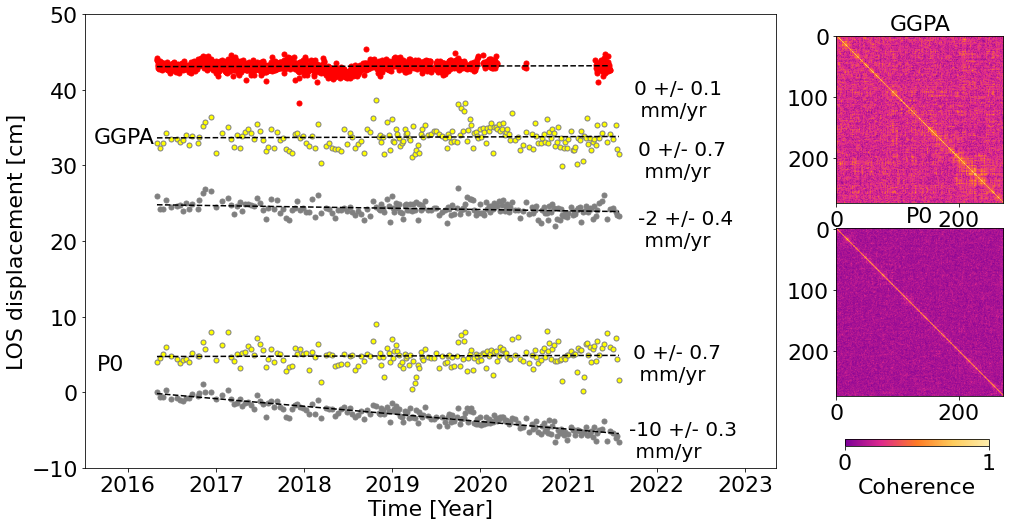

In [53]:
plt.rcParams["font.size"] = "22"

years = mdates.YearLocator()


fig = plt.figure(figsize=(20, 10), constrained_layout=False)
gs1 = fig.add_gridspec(nrows=1, ncols=1, left=0.02, right=0.5, top=0.98, bottom=0.35,
                        hspace=0.2, wspace=0.2)
ax1 = fig.add_subplot(gs1[0,0])

gs2 = fig.add_gridspec(nrows=2, ncols=1, left=0.45, right=0.75, top=0.95, bottom=0.45,
                        hspace=0.15, wspace=0.2)


ax2 = fig.add_subplot(gs2[0,0])
ax3 = fig.add_subplot(gs2[1,0])

ax1.plot(xx_ggpa, dlos_minopy_ggpa[ind_ggpa::] - dlos_ggpa_intp_minopy - dlos_minopy_ggpa[ind_ggpa] + dlos_ggpa_intp_minopy[0] + 44 , 'o',markersize=5, color='red')

ax1.plot(dates_minopy[ind_minopy::], ts_minopy[0, ind_minopy::] - ts_minopy[0, ind_minopy] + 33, 'o', markersize=5, markerfacecolor='yellow', markeredgecolor='gray')

ax1.plot(dates_mintpy[ind_mintpy::], ts_mintpy[0, ind_mintpy::] - ts_mintpy[0, ind_mintpy] + 26, 'o', markersize=5, markerfacecolor='gray', markeredgecolor='gray')




ax1.plot(dates_mintpy[ind_mintpy::], ts_mintpy[1, ind_mintpy::] - ts_mintpy[1, ind_mintpy] , 'o', markerfacecolor='gray', 
             markeredgecolor='gray', markersize=5)

ax1.plot(dates_minopy[ind_minopy::], ts_minopy[1, ind_minopy::] - ts_minopy[1, ind_minopy] +4, 'o', markerfacecolor='yellow', 
             markeredgecolor='gray', markersize=5)

x_mintpy = [(x-dates_mintpy[ind_mintpy]).days for x in dates_mintpy[ind_mintpy::]] 
x_minopy = [(x-dates_minopy[ind_minopy]).days for x in dates_minopy[ind_minopy::]] 

fs = 20

res = stats.linregress(x_mintpy, ts_mintpy[0, ind_mintpy::] - ts_mintpy[0, ind_mintpy] + 26)
ax1.plot(dates_mintpy[ind_mintpy::], res.intercept + res.slope * np.array(x_mintpy), 'k--')
ax1.text(dates_mintpy[-1] + timedelta(days=80), ts_mintpy[0, -1] - ts_mintpy[0, ind_mintpy] + 22, 
         '{:.0f} +/- {:.1f}\n mm/yr'.format(res.slope*365.25*10, res.stderr*365.25*10), fontsize=fs)
   
res = stats.linregress(x_minopy, ts_minopy[0, ind_minopy::] - ts_minopy[0, ind_minopy] + 33)
ax1.plot(dates_minopy[ind_minopy::], res.intercept + res.slope * np.array(x_minopy), 'k--')
ax1.text(dates_minopy[-1] + timedelta(days=80), ts_minopy[0, -1] - ts_minopy[0, ind_minopy] + 30, 
         '{:.0f} +/- {:.1f}\n mm/yr'.format(res.slope*365.25*10, res.stderr*365.25*10), fontsize=fs)

res = stats.linregress(xx_ggpa_d, dlos_minopy_ggpa[ind_ggpa::] - dlos_ggpa_intp_minopy - dlos_minopy_ggpa[ind_ggpa] + dlos_ggpa_intp_minopy[0] + 44)
ax1.plot(xx_ggpa, res.intercept + res.slope * np.array(xx_ggpa_d), 'k--')
ax1.text(xx_ggpa[-1] +  timedelta(days=100), dlos_minopy_ggpa[-1] - dlos_ggpa_intp_minopy[-1] - dlos_minopy_ggpa[ind_ggpa] + dlos_ggpa_intp_minopy[0] + 38, 
         '{:.0f} +/- {:.1f}\n mm/yr'.format(res.slope*365.25*10, res.stderr*365.25*10), fontsize=fs)

res = stats.linregress(x_mintpy, ts_mintpy[1, ind_mintpy::] - ts_mintpy[1, ind_mintpy])
ax1.plot(dates_mintpy[ind_mintpy::], res.intercept + res.slope * np.array(x_mintpy), 'k--')
ax1.text(dates_mintpy[-1] + timedelta(days=40), ts_mintpy[1, -1] - ts_mintpy[1, ind_mintpy]-2 , 
         '{:.0f} +/- {:.1f}\n mm/yr'.format(res.slope*365.25*10, res.stderr*365.25*10), fontsize=fs)
   
res = stats.linregress(x_minopy, ts_minopy[1, ind_minopy::] - ts_minopy[1, ind_minopy] +4)
ax1.plot(dates_minopy[ind_minopy::], res.intercept + res.slope * np.array(x_minopy), 'k--')
ax1.text(dates_minopy[-1] + timedelta(days=60), ts_minopy[1, -1] - ts_minopy[1, ind_minopy] + 4, 
         '{:.0f} +/- {:.1f}\n mm/yr'.format(res.slope*365.25*10, res.stderr*365.25*10), fontsize=fs)


ax1.text(dates_minopy[ind_minopy] - timedelta(days=260), 33, 'GGPA', color='black')
ax1.text(dates_minopy[ind_minopy] - timedelta(days=250), 3, 'P0', color='black')

ax2.set_title('GGPA', fontsize=22)
ax3.set_title('P0', fontsize=22)

ax1.set_ylim(-10,50)
ax1.set_xlim(dates_minopy[ind_minopy] - timedelta(days=300), dates_minopy[-1] + timedelta(days=650))

ax1.set_ylabel('LOS displacement [cm]')
#ax1.set_xlabel(False)
ax1.get_xaxis().set_ticks([])
ax1.tick_params()
#ax1.legend(( 'GPS','Sequential EMI', 'Small baseline'), loc='lower left')


years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')
ax1.xaxis.set_major_locator(years)
ax1.xaxis.set_major_formatter(years_fmt)
ax1.set_xlabel('Time [Year]')

im3=ax2.imshow(np.abs(np.array(coh_mat_1)), vmin=0, vmax=1, cmap=cmapc)
ax3.imshow(np.abs(np.array(coh_mat_2)), vmin=0, vmax=1, cmap=cmapc)

cbar_ax2 = fig.add_axes([0.548, 0.38, 0.1, 0.01])
#cbar_ax2 = fig.add_axes([0.5, 0.01, 0.005, 0.15, ])
fig.colorbar(im3, cax=cbar_ax2, ticks=[0, 1], label='Coherence', orientation='horizontal')


plt.savefig(out_dir+'/ts_coh_mat_pichincha.png', bbox_inches='tight', transparent=True)
plt.savefig(out_dir+'/ts_coh_mat_pichincha.eps', bbox_inches='tight', transparent=True)

plt.show()